In [1]:
%matplotlib inline

import pandas as pd

In [ ]:
# HERE show what is in the files

In [2]:
year = 2017
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

chunks = []
for month in months:
    filename = template.format(year=year, month=month)
    print(filename)

    chunk_iterator = pd.read_csv(filename, sep=',', chunksize=chunksize)
    for chunk in chunk_iterator:
        chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
        
        chunk_sum = pd.DataFrame(
            data={
                'MORNING': chunk['TV_M'] + chunk['VOD_M'],
                'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
                'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
                'USER_ID': chunk['USER_ID'],
                'YEAR_MONTH': month,
            }
        )
        chunks.append(chunk_sum)

df = pd.concat(chunks)

consumption_201710.csv
consumption_201711.csv
consumption_201712.csv


In [3]:
df.head()

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,10
1,3211,2483,6816,1,10
2,1959,1403,3448,2,10
3,1722,1568,4450,3,10
4,605,457,1338,4,10


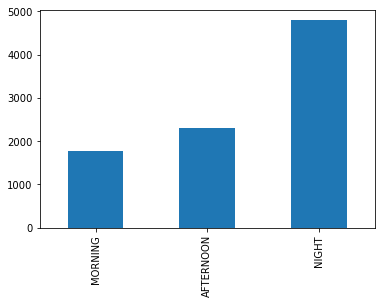

In [4]:
df.loc[:, ['MORNING', 'AFTERNOON', 'NIGHT']].mean().plot.bar()

In [74]:
years = [2017]
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

def iterate_months_in_chunks(months, year, chunksize):
    template = 'consumption_{year}{month}.csv'
    for year in years:
        for month in months:
            filename = template.format(month=month, year=year)
            for chunk in pd.read_csv(filename, sep=',', chunksize=chunksize):
                chunk['YEAR'] = year
                chunk['MONTH'] = month
                yield chunk

def clean_chunks(chunks):
    for chunk in chunks:
        year = chunk['YEAR'].values[0]
        month = chunk['MONTH'].values[0]
        chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
        yield chunk

def aggregate_chunks_by_part_of_day(chunks):
    for chunk in chunks:
        chunk_sum = pd.DataFrame(
            data={
                'MORNING': chunk['TV_M'] + chunk['VOD_M'],
                'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
                'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
                'USER_ID': chunk['USER_ID'],
                'YEAR_MONTH': chunk['YEAR'] * 100 + chunk['MONTH'],
            }
        )
        yield chunk_sum


In [75]:
# First...
agg_chunks = []
for agg_chunk in aggregate_chunks_by_part_of_day(clean_chunks(iterate_months_in_chunks(months, year, chunksize))):
    agg_chunks.append(agg_chunk)

df = pd.concat(agg_chunks)
df.head()

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,201710
1,3211,2483,6816,1,201710
2,1959,1403,3448,2,201710
3,1722,1568,4450,3,201710
4,605,457,1338,4,201710


In [76]:
# Second...
agg_chunks = list(aggregate_chunks_by_part_of_day(clean_chunks(iterate_months_in_chunks(months, year, chunksize))))
df = pd.concat(agg_chunks)
df.head()

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,201710
1,3211,2483,6816,1,201710
2,1959,1403,3448,2,201710
3,1722,1568,4450,3,201710
4,605,457,1338,4,201710


In [78]:
# Or just...
df = pd.concat(
        aggregate_chunks_by_part_of_day(clean_chunks(iterate_months_in_chunks(months, year, chunksize)))
     )
df.head()

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,201710
1,3211,2483,6816,1,201710
2,1959,1403,3448,2,201710
3,1722,1568,4450,3,201710
4,605,457,1338,4,201710


In [77]:
# When we need to do it again with another aggregation...

def aggregate_chunk_by_service(chunks):
    for chunk in chunks:
        chunk_sum = pd.DataFrame(
            data={
                'TV': chunk['TV_M'] + chunk['TV_A'] + chunk['TV_N'],
                'VOD': chunk['VOD_M'] + chunk['VOD_A'] + chunk['VOD_N'],
                'USER_ID': chunk['USER_ID'],
                'YEAR_MONTH': chunk['YEAR'] * 100 + chunk['MONTH'],
            }
        )
        yield chunk_sum

df = pd.concat(
        aggregate_chunk_by_service(clean_chunks(iterate_months_in_chunks(months, year, chunksize)))
     )
df.head()

,TV,USER_ID,VOD,YEAR_MONTH
0,8490,0,4650,201710
1,6300,1,6210,201710
2,5910,2,900,201710
3,1560,3,6180,201710
4,1230,4,1170,201710
